In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
from torchvision.models import resnet18
# from get_myDataset import MyDataset

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import numpy as np

# 定义读取文件的格式
def default_loader(path):
    return Image.open(path).convert('RGB')

# 创建自己的类：MyDataset, 继承 Dataset类
class MyDataset(Dataset):
    def __init__(self, txt, data_path=None, transform=None, target_transform=None, loader=default_loader):
        super(MyDataset, self).__init__() # 对继承父类的属性初始化
        # 在__init__()方法中得到图像的路径，然后将图像路径组成一个数组
        file_path = data_path + txt
        file = open(file_path, 'r')
        imgs = []
        for line in file:
            line = line.split()
            # print(line[0].rstrip(','))  # img
            # print(line[1].rstrip('\n'))  # label
            imgs.append((line[0].rstrip(','), line[1].rstrip('\n')))
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.data_path = data_path

    def __getitem__(self, index):
        # 按照索引读取每个元素的具体内容
        imgName, label = self.imgs[index]
        imgPath = self.data_path + imgName
        img = self.loader(imgPath)
        if self.transform is not None:
            img = self.transform(img)  # 数据标签转换为Tensor
            label = torch.from_numpy(np.array(int(label)))
        return img, label

    def __len__(self):
        # 数据集的图片数量
        return len(self.imgs)




In [ ]:
from torchvision.models import resnet18
print(resnet18())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(resnet18().conv1,
                                      resnet18().bn1,
                                      resnet18().relu,
                                      resnet18().maxpool,
                                      resnet18().layer1,
                                      resnet18().layer2,
                                      resnet18().layer3,
                                      resnet18().layer4)
        self.classifiers = nn.Sequential(nn.Linear(512**2, 14))
        
    def forward(self, x):
        x = self.features(x)
        batch_size = x.size(0)
        x = x.view(batch_size, 512, x.size(2) ** 2)
        x = (torch.bmm(x, torch.transpose(x, 1, 2)) / (x.size(2) ** 2)).view(batch_size, -1)
        x = torch.nn.functional.normalize(torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10))
        x = self.classifiers(x)
        return x

![](https://pic4.zhimg.com/80/v2-67c1b41dff89e3f5b620a16d2440e2f7_1440w.jpg)

In [ ]:
my_resnet = Net()
print(my_resnet)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:

# 预处理的设置
# 图片转化为resnet规定的图片大小
# 归一化是减去均值，除以方差
# 把 numpy array 转化为 tensor 的格式
train_tf = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.557, 0.517, 0.496], [0.210, 0.216, 0.222])])
'''
normMean = [0.55671153 0.51730426 0.49580584]
normStd = [0.21057842 0.21577705 0.222336]
'''

test_tf = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize([0.557, 0.517, 0.496], [0.210, 0.216, 0.222])])

# 数据集加载方式设置
cmd_path = '/content/drive/My Drive/week10_dataset/'
train_data = MyDataset(txt='train_set_0.txt', data_path=cmd_path, transform=train_tf)
test_data = MyDataset(txt='test_set_0.txt', data_path=cmd_path, transform=test_tf)

# 调用DataLoader和数据集
train_loader = DataLoader(dataset=train_data, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
# my_resnet = Net()

# 超参数设置
learn_rate = 0.0001
num_epoches = 70
# 多分类损失函数，使用默认值
criterion = nn.CrossEntropyLoss()
# 梯度下降，求解模型最后一层参数
# optimizer = optim.SGD(my_resnet.parameters(), lr=learn_rate, momentum=0.9)
optimizer = optim.Adam(my_resnet.parameters(), lr=learn_rate, betas=(0.9, 0.99))
# # 学习率的调整
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
#                                                  factor=0.1, patience=3, 
#                                                  verbose=True, threshold=1e-4)

# 判断使用CPU还是GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 训练阶段
my_resnet.to(device)
my_resnet.train()
for epoch in range(num_epoches):
    print(f"epoch: {epoch+1}")
    for idx, (img, label) in enumerate(train_loader):
        images = img.to(device)
        labels = label.to(device)
        output = my_resnet(images)
        loss = criterion(output, labels)
        loss.backward()  # 损失反向传播
        optimizer.step()  # 更新梯度
        # scheduler.step()
        optimizer.zero_grad()  # 梯度清零
        if idx % 100 == 0:
            print(f"current loss = {loss.item()}")



epoch: 1
current loss = 2.6380772590637207
epoch: 2
current loss = 2.411803722381592
epoch: 3
current loss = 2.4133870601654053
epoch: 4
current loss = 2.1762945652008057
epoch: 5
current loss = 1.9517539739608765
epoch: 6
current loss = 1.5074641704559326
epoch: 7
current loss = 1.6162376403808594
epoch: 8
current loss = 1.9696271419525146
epoch: 9
current loss = 1.5991138219833374
epoch: 10
current loss = 1.2982730865478516
epoch: 11
current loss = 1.126551866531372
epoch: 12
current loss = 1.685489535331726
epoch: 13
current loss = 1.4231361150741577
epoch: 14
current loss = 1.4450786113739014
epoch: 15
current loss = 1.2470965385437012
epoch: 16
current loss = 0.8976471424102783
epoch: 17
current loss = 1.1372499465942383
epoch: 18
current loss = 0.5460026860237122
epoch: 19
current loss = 1.7343571186065674
epoch: 20
current loss = 0.8780317902565002
epoch: 21
current loss = 0.9021095037460327
epoch: 22
current loss = 1.0909196138381958
epoch: 23
current loss = 1.0901718139648438


In [ ]:
# 测试阶段
my_resnet.to(device)
my_resnet.eval()  # 把训练好的模型的参数冻结
total, correct = 0, 0
for img, label in test_loader:
    images = img.to(device)
    labels = label.to(device)
    #print("label: ",labels)
    output = my_resnet(images)
    #print("output:", output.data.size)
    _, idx = torch.max(output.data, 1) # 输出最大值的位置
    #print("idx: ", idx)
    total += labels.size(0) # 全部图片
    correct += (idx == labels).sum() # 正确的图片
    #print("correct_num: %f",correct)
print("correct_num: ", correct)
print("total_image_num: ", total)
print(f"accuracy:{100.*correct/total}")

correct_num:  tensor(25, device='cuda:0')
total_image_num:  30
accuracy:83.33333587646484


In [ ]:
model_name = 'Bilinear_resnet_model.pkl'
save_path = '/content/' + model_name
torch.save(my_resnet, save_path)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
label_idx = dict({'农夫山泉': 0, '冰露': 1, '娃哈哈': 2,
                  '可口可乐': 3, '天府可乐': 4, '其它': 5,
                  '康师傅': 6, '百事可乐': 7, '怡宝': 8,
                  '百岁山': 9, '苏打水': 10, '景甜': 11,
                  '恒大冰泉': 12, '今麦郎': 13}
)

idx_label = dict({'0': '农夫山泉', '1': '冰露', '2': '娃哈哈', 
                 '3': '可口可乐', '4': '天府可乐', '5': '其它', 
                 '6': '康师傅', '7': '百事可乐', '8': '怡宝', 
                 '9': '百岁山', '10': '苏打水', '11': '景甜', 
                 '12': '恒大冰泉', '13': '今麦郎'})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  5
idx:  5
预测标签名称：  其它


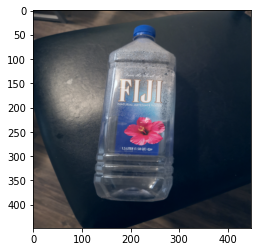

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  8
idx:  8
预测标签名称：  怡宝


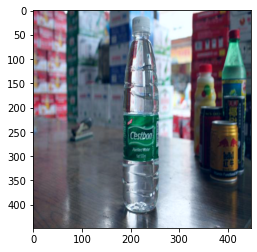

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  8
idx:  0
预测标签名称：  农夫山泉


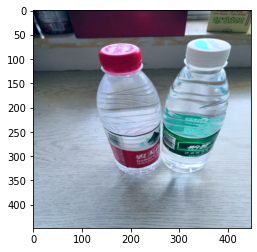

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  9
idx:  9
预测标签名称：  百岁山


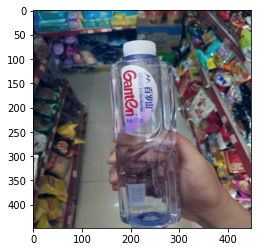

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  2
idx:  11
预测标签名称：  景甜


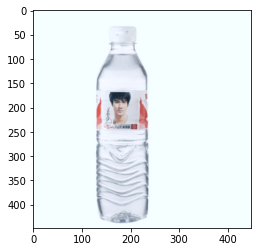

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  8
idx:  8
预测标签名称：  怡宝


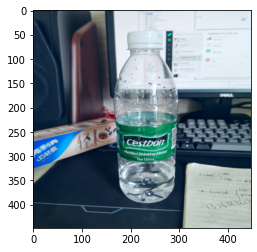

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  4
idx:  4
预测标签名称：  天府可乐


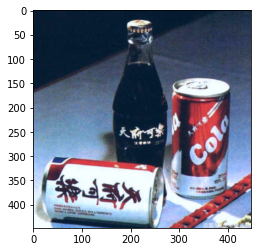

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  2
idx:  2
预测标签名称：  娃哈哈


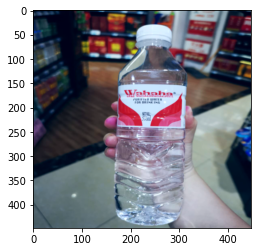

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  12
idx:  12
预测标签名称：  恒大冰泉


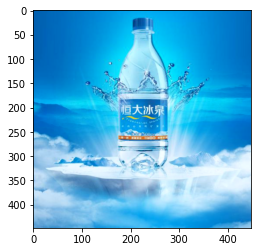

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  1
idx:  1
预测标签名称：  冰露


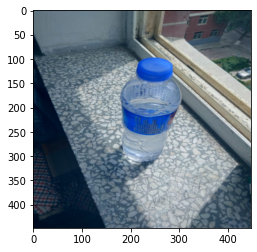

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  8
idx:  8
预测标签名称：  怡宝


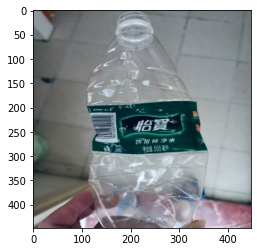

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  0
idx:  0
预测标签名称：  农夫山泉


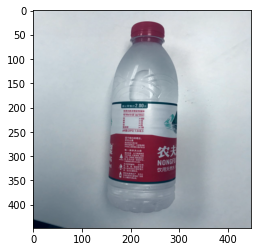

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  1
idx:  5
预测标签名称：  其它


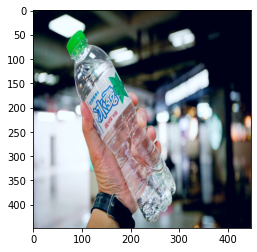

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  0
idx:  0
预测标签名称：  农夫山泉


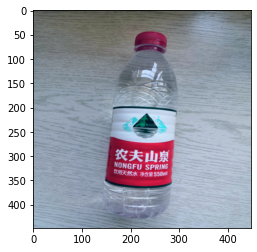

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  2
idx:  1
预测标签名称：  冰露


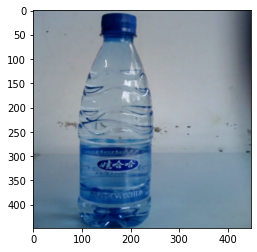

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  13
idx:  13
预测标签名称：  今麦郎


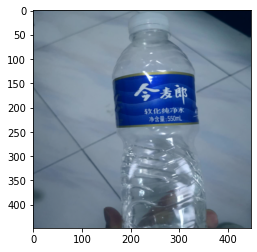

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  1
idx:  1
预测标签名称：  冰露


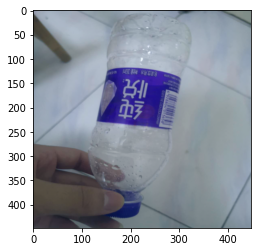

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  5
idx:  5
预测标签名称：  其它


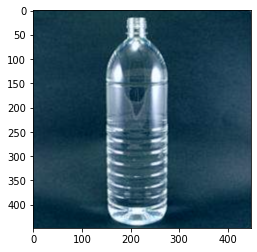

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  0
idx:  0
预测标签名称：  农夫山泉


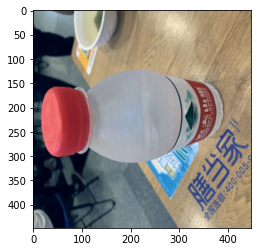

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  9
idx:  9
预测标签名称：  百岁山


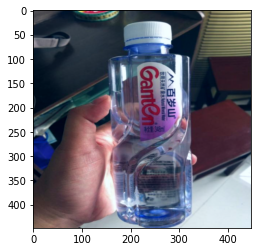

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  10
idx:  10
预测标签名称：  苏打水


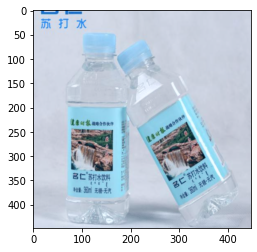

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  4
idx:  4
预测标签名称：  天府可乐


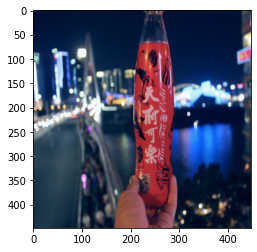

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  0
idx:  0
预测标签名称：  农夫山泉


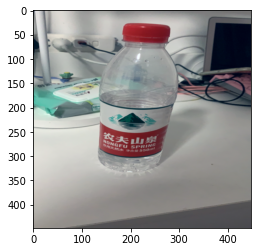

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  8
idx:  8
预测标签名称：  怡宝


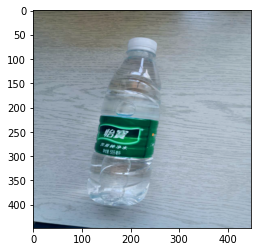

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  2
idx:  2
预测标签名称：  娃哈哈


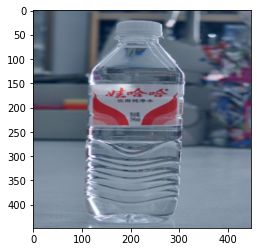

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  4
idx:  4
预测标签名称：  天府可乐


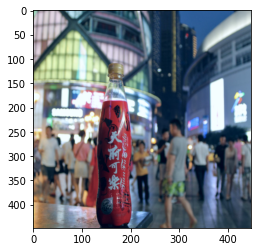

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  4
idx:  4
预测标签名称：  天府可乐


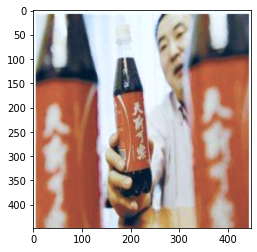

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  5
idx:  5
预测标签名称：  其它


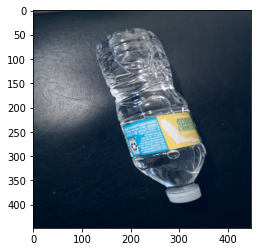

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  2
idx:  2
预测标签名称：  娃哈哈


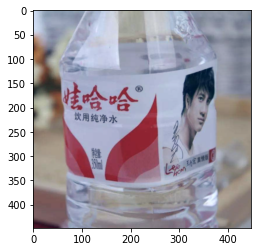

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label:  5
idx:  3
预测标签名称：  可口可乐


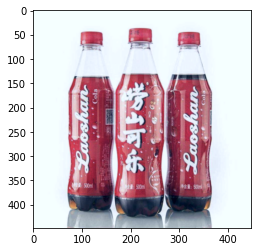

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

i = 0
normMean = [0.557, 0.517, 0.496]
normStd = [0.210, 0.216, 0.222]
normMean.reverse()
normStd.reverse()

for img, label in test_loader:
    images = img.to(device)
    labels = label.to(device)
    print("label: ",labels.item())
    output = my_resnet(images)
#     print("output:", output.data.size)
    _, idx = torch.max(output.data, 1) # 输出最大值的位置
    print("idx: ", idx.item())
    print('预测标签名称： ', idx_label[str(idx.item())])
    img = img[0,:,:,:].numpy()
    img = np.transpose(img, (1, 2, 0)) 

    img[:,:,0] = img[:,:,0]*normStd[0] + normMean[0]
    img[:,:,1] = img[:,:,1]*normStd[1] + normMean[1]
    img[:,:,2] = img[:,:,2]*normStd[2] + normMean[2]
    plt.ion()
    plt.imshow((img))
    plt.pause(5)
    plt.close()
    i += 1
#     print(img)
    if i == 30:
        break
plt.show()